In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Ensure 'results' directory exists
os.makedirs('results', exist_ok=True)


In [29]:
# Predefined severity levels for stakeholders
severity_levels = {
    'Artists/content creators': 1,
    'Business': 2,
    'Investors': 3,
    'Workers': 5,
    'Users': 6,
    'Vulnerable groups': 8,
    'Government/public sector': 9,
    'General public': 10,
    'Subjects': 1,
    'Government/public service': 9
    # Add other stakeholders and their severity levels as needed
}

In [30]:
# Load the detailed CSV
df = pd.read_csv(r'C:\Users\Sofia\PycharmProjects\aiaaic-harms-severity\results\categories_stakeholders_detailed.csv')

# Print all unique stakeholder names
unique_stakeholders = df['stakeholders'].unique()
print("Unique stakeholders in the dataset:")
for stakeholder in unique_stakeholders:
    print(stakeholder)


Unique stakeholders in the dataset:
Artists/content creators
General public
Government/public sector
Users
Vulnerable groups
Workers
Business
Investors
Subjects
Government/public service


In [31]:
# Map severity levels from the predefined dictionary
df['severity'] = df['stakeholders'].map(severity_levels)

# Handle cases where severity is not available
df['severity'].fillna(1, inplace=True)  # Default severity to 1 if not provided

# Initialize a list to collect all cumulative proportions
all_cumulative_proportions = []


In [32]:
# Function to compute the Gini index using Wikipedia's discrete formula
def calculate_gini_for_category(df, category):
    # Filter by category
    df_category = df[df['harm_category'] == category].copy()  # Use copy() to avoid modifying the original DataFrame

    # Sort by severity
    df_category = df_category.sort_values(by='severity')

    # Get severity and frequency arrays
    y = df_category['severity'].values
    f = df_category['freq'].values

    # Calculate mean severity (μ)
    μ = np.sum(y * f) / np.sum(f)

    # Double summation for Gini coefficient
    n = len(y)
    G = 0
    for i in range(n):
        for j in range(n):
            G += f[i] * f[j] * np.abs(y[i] - y[j])

    G = G / (2 * μ * np.sum(f) * np.sum(f))  # Normalizing by 2 * μ and total weights

    # Calculate cumulative frequency for the Lorenz curve visualization
    df_category['cum_freq'] = df_category['freq'].cumsum()
    total_freq = df_category['freq'].sum()
    df_category['cumulative_proportion'] = df_category['cum_freq'] / total_freq

    # Append to the list for cumulative proportions
    all_cumulative_proportions.append(df_category)

    # Print the category and the Gini index
    print(f'\nCategory: {category}, Gini Index: {G:.2f}')

    return G

In [33]:
# Calculate Gini index for each harm category
categories = df['harm_category'].unique()
gini_indices = {}
for category in categories:
    gini_index = calculate_gini_for_category(df, category)
    gini_indices[category] = gini_index

# Concatenate all cumulative proportions into a single DataFrame
all_cumulative_df = pd.concat(all_cumulative_proportions)


Category: Autonomy, Gini Index: 0.27

Category: Emotional & psychological, Gini Index: 0.13

Category: Financial & business, Gini Index: 0.34

Category: Human rights & civil liberties, Gini Index: 0.17

Category: Physical, Gini Index: 0.10

Category: Political & economic, Gini Index: 0.05

Category: Psychological, Gini Index: 0.18

Category: Reputational, Gini Index: 0.21

Category: Societal & cultural, Gini Index: 0.21


In [34]:
# Create the final DataFrame for cumulative proportions
df_final = all_cumulative_df[['harm_category', 'stakeholders', 'freq']].copy()
df_final['Sev'] = all_cumulative_df['severity']
df_final['Cumulative'] = all_cumulative_df['cumulative_proportion']

# Save the final DataFrame to Excel
df_final.to_excel('results/summary_with_severity_and_cumulative.xlsx', index=False)

# Save the Gini indices as a CSV
gini_df = pd.DataFrame(list(gini_indices.items()), columns=['harm_category', 'gini_index'])
gini_df.to_csv('results/gini_indices_wikipedia.csv', index=False)

print("\nGini indices:")
print(gini_df)


Gini indices:
                    harm_category  gini_index
0                        Autonomy    0.266520
1       Emotional & psychological    0.131944
2            Financial & business    0.343634
3  Human rights & civil liberties    0.172941
4                        Physical    0.096254
5            Political & economic    0.052693
6                   Psychological    0.184002
7                    Reputational    0.211374
8             Societal & cultural    0.208548


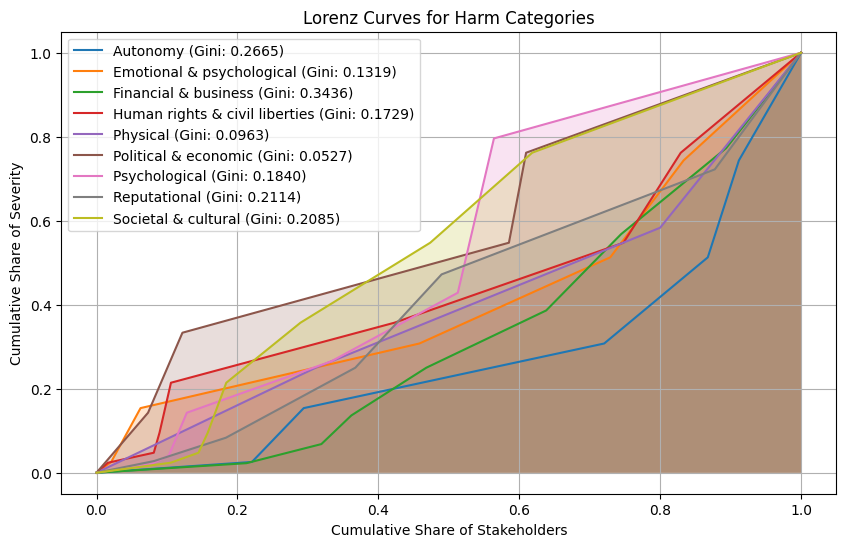

In [36]:
# ---- Start of Lorenz Curve Plotting ----

# Initialize a new plot for Lorenz curves
plt.figure(figsize=(10, 6))

# Function to calculate and plot Lorenz curves for each harm category
def plot_lorenz_curve(df, category):
    # Filter by category
    df_category = df[df['harm_category'] == category].copy()

    # Sort by severity
    df_category = df_category.sort_values(by='severity')

    # Calculate cumulative frequency and severity
    df_category['cum_freq'] = df_category['freq'].cumsum()
    df_category['cum_severity'] = df_category['severity'].cumsum()

    # Normalize cumulative frequency and cumulative severity
    df_category['cum_freq_norm'] = df_category['cum_freq'] / df_category['freq'].sum()
    df_category['cum_severity_norm'] = df_category['cum_severity'] / df_category['severity'].sum()

    # Insert (0,0) to start the Lorenz curve from the origin
    df_category = pd.concat([pd.DataFrame({'cum_freq_norm': [0], 'cum_severity_norm': [0]}), df_category])

    # Generate x-axis values representing cumulative share of stakeholders
    x_values = df_category['cum_freq_norm']

    # Plot the Lorenz curve
    plt.plot(x_values, df_category['cum_severity_norm'], label=f'{category} (Gini: {gini_indices[category]:.4f})')
    plt.fill_between(x_values, 0, df_category['cum_severity_norm'], alpha=0.2)


# Plot Lorenz curve for each harm category
for category in categories:
    plot_lorenz_curve(df, category)

# Customize and display the Lorenz curve plot
plt.title('Lorenz Curves for Harm Categories')
plt.xlabel('Cumulative Share of Stakeholders')
plt.ylabel('Cumulative Share of Severity')
plt.legend()
plt.grid(True)
plt.show()
